# Estimacion de Densidad

September 28, 2018

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv('./data/SDSS_Gals.csv')
df.head()

,z,petroRad_r_kpc,absPetroMag_r
0,0.123945,16.159371,-21.933832
1,0.091500,10.336046,-21.383353
2,0.077116,15.770359,-21.973098
3,0.185233,18.595973,-21.888694
4,0.094941,8.508556,-21.342373


El objetivo en estimacion de densidad es construir la **función de densidad de probabilidad** desde los datos.

La manera mas simple de estimar la densidad es utilizando un histograma

In [3]:
z = np.array(df['z']) # tomamos el valor de z (redshift)

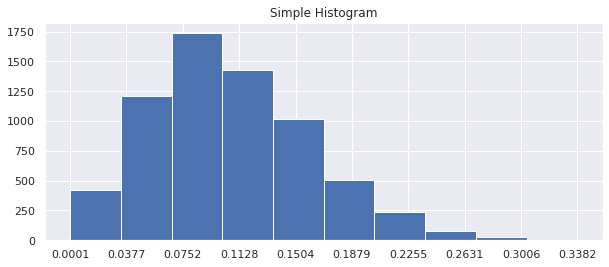

[ 421. 1207. 1737. 1430. 1014.  504.  240.   79.   26.    4.]


In [4]:
plt.figure(figsize=(10,4))
n, _, _ = plt.hist(z, bins = 10)
plt.title('Simple Histogram')
plt.xticks(np.linspace(min(z),max(z), 10))
plt.show()
print(n) #The values of the histogram bin

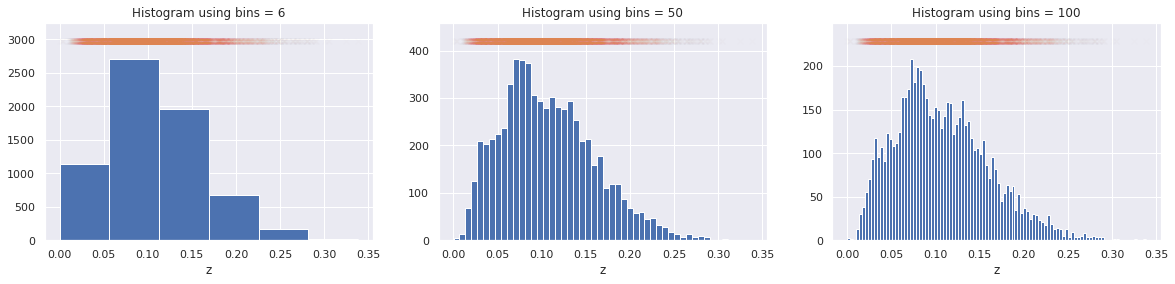

In [10]:
bins = [6, 50, 100]

plt.figure(figsize=(20,4))
for index, b in enumerate(bins):
    pos = int(str(13)+str(index+1))
    plt.subplot(pos)
    
    n, _, _ = plt.hist(z, bins = b)
    plt.plot (z, np.ones(len(z))*n.max()*1.1, "x", alpha = 0.01)
    plt.title('Histogram using bins = '+str(b))
    plt.ylim([0, n.max()*1.2])
    plt.xlabel("z")
plt.show()

La definicion de los bins afecta en la estimacion de la distribucion. A continuacion mostraremos **Kernel Density Estimation** la cual es una tecnica no parametrica para estimar la funcion de densidad.

## Kernel Density Estimation

* Cada punto es descrito por un *Kernel*.
* La probabilidad de la funcion de densidad es estimada desde la suma de todos los kernels.
* $\hat{f}_h(x) = \frac{1}{n}\sum K_h(x-x_i) = \frac{1}{nh}\sum K(\frac{x-x_i}{h})$
* $h$ es el ancho de banda el cual define el tamano del kernel

<img style='float: left;' src='./figures/KDE1.png'>
<img style='float: right;' src='./figures/KDE2.png'>

In [6]:
from sklearn.neighbors import KernelDensity

#### Kernels disponibles
<img  height="150" width="450" style='float: right;' src='./figures/kernels.png'>
<p style='float: left;'>
- Gaussian kernel $\rightarrow$ (kernel = 'gaussian')<br><br>
- Tophat kernel $\rightarrow$ (kernel = 'tophat')<br><br>
- Epanechnikov kernel $\rightarrow$ (kernel = 'epanechnikov')<br><br>
- Exponential kernel $\rightarrow$ (kernel = 'exponential')<br><br>
- Linear kernel $\rightarrow$ (kernel = 'linear')<br><br>
- Cosine kernel $\rightarrow$ (kernel = 'cosine')<br><br>
</p>

In [8]:
kde = KernelDensity(kernel='gaussian',bandwidth = 1e-2)
kde.fit(z[:, None])

KernelDensity(bandwidth=0.01)

In [11]:
x = np.arange(0, 0.5, 0.01)
# score_samples returns the log of the probability density
prob = np.exp(kde.score_samples (x[:, None]))

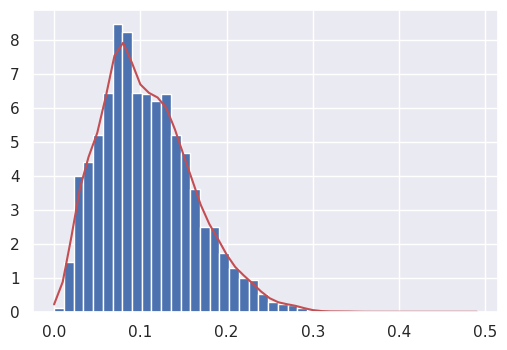

In [12]:
plt.figure(dpi=100)
plt.hist(z, bins = 30, density=True)
plt.plot(x, prob, "r")
plt.show()

El ancho de banda es un hiperparametro que debemos ajustar utilizando **cross-validation**

In [13]:
from sklearn.model_selection import GridSearchCV 

z = np.array(df.sample(100)['z'])

params = {'bandwidth': np.logspace(-3, 0, 20)}

grid = GridSearchCV(KernelDensity(), params)
grid = grid.fit(z[:, None])

In [16]:
results = pd.DataFrame(grid.cv_results_)
results.sample(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.000192,0.000010,0.000178,0.000015,0.01833,{'bandwidth': 0.018329807108324356},32.588440,24.785759,31.142514,33.556915,31.966182,30.807962,3.112786,2
18,0.000204,0.000018,0.000188,0.000033,0.695193,{'bandwidth': 0.6951927961775606},-11.204962,-11.256501,-11.223219,-11.214549,-11.219182,-11.223682,0.017501,17
12,0.000400,0.000079,0.000337,0.000017,0.078476,{'bandwidth': 0.07847599703514611},26.598323,23.430798,25.689306,26.402874,25.868462,25.597953,1.133730,9


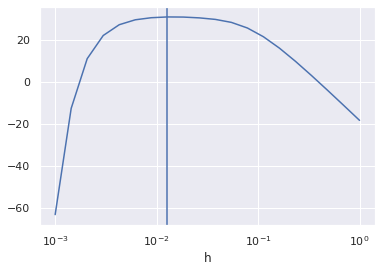

In [17]:
plt.figure()
plt.plot(results['param_bandwidth'], results['mean_test_score'])
plt.xlabel ("h")
plt.axvline(grid.best_estimator_.bandwidth)
plt.xscale("log")
plt.show()

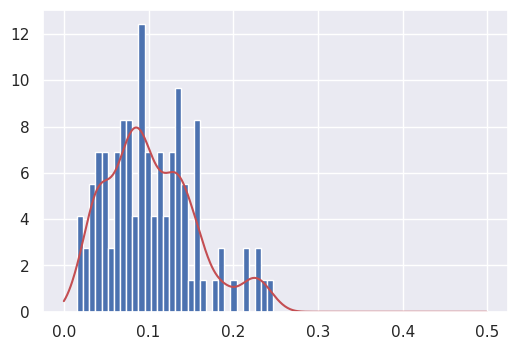

In [20]:
x = np.arange(0, 0.5, 0.001)

pdf = np.exp(grid.best_estimator_.score_samples(x[:, None]))

plt.figure(dpi=100)
plt.hist(z, bins = 32, density = True)
plt.plot(x, pdf, "r")
plt.show()